In [12]:
import sys
sys.path.insert(0,"..")
from queuerious_detector.interpret import *
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from joblib import dump
from xgboost import XGBClassifier

In [13]:
# load dfs and embeddings
train_df = pd.read_csv("../data/processed/train_tickets.csv")
val_df = pd.read_csv("../data/processed/val_tickets.csv")
test_df = pd.read_csv("../data/processed/test_tickets.csv")

X_train = np.load("../data/processed/X_train_sbert.npy")
X_val = np.load("../data/processed/X_val_sbert.npy")
X_test = np.load("../data/processed/X_test_sbert.npy")

# encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_df["queue_grouped"])
y_val = le.transform(val_df["queue_grouped"])
y_test = le.transform(test_df["queue_grouped"])

In [16]:
from sklearn.utils.class_weight import compute_sample_weight

#since our data is imbalanced, we will use sklearn's compute_sample_weight
sample_weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

In [ ]:
# using paramers from the previous notebook by Alyna
clf = XGBClassifier(
    objective="multi:softmax",
    eval_metric="merror",
    num_class=len(le.classes_),
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    n_estimators = 600,
    min_child_weight = 4, 
    max_depth = 5, 
    learning_rate = 0.1,
    gamma= 1, 
    colsample_bytree = 0.7,
    subsample=0.8,
    reg_lambda=1.5,
    reg_alpha=0.05
)
clf.fit(X_train, y_train,
    sample_weight=sample_weight_train,
    eval_set=[(X_val, y_val)],
    verbose=False)

In [ ]:
# predict on validation and test sets
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)

print(
    "Validation Classification Report:\n",
    classification_report(y_val, y_val_pred, target_names=le.classes_),
)
print(
    "Test Classification Report:\n",
    classification_report(y_test, y_test_pred, target_names=le.classes_),
)

Validation Classification Report:
                                        precision    recall  f1-score   support

                 Billing and Payments       0.86      0.80      0.83       288
Customer Service, Returns & Exchanges       0.55      0.61      0.58       582
                      General Inquiry       0.85      0.27      0.41        41
                      Human Resources       0.74      0.53      0.62        60
                      Product Support       0.55      0.56      0.55       547
                  Sales and Pre-Sales       0.69      0.47      0.56        90
      Service Outages and Maintenance       0.74      0.68      0.70       120
               Technical & IT Support       0.72      0.74      0.73      1222

                             accuracy                           0.66      2950
                            macro avg       0.71      0.58      0.62      2950
                         weighted avg       0.67      0.66      0.66      2950

Test Classific

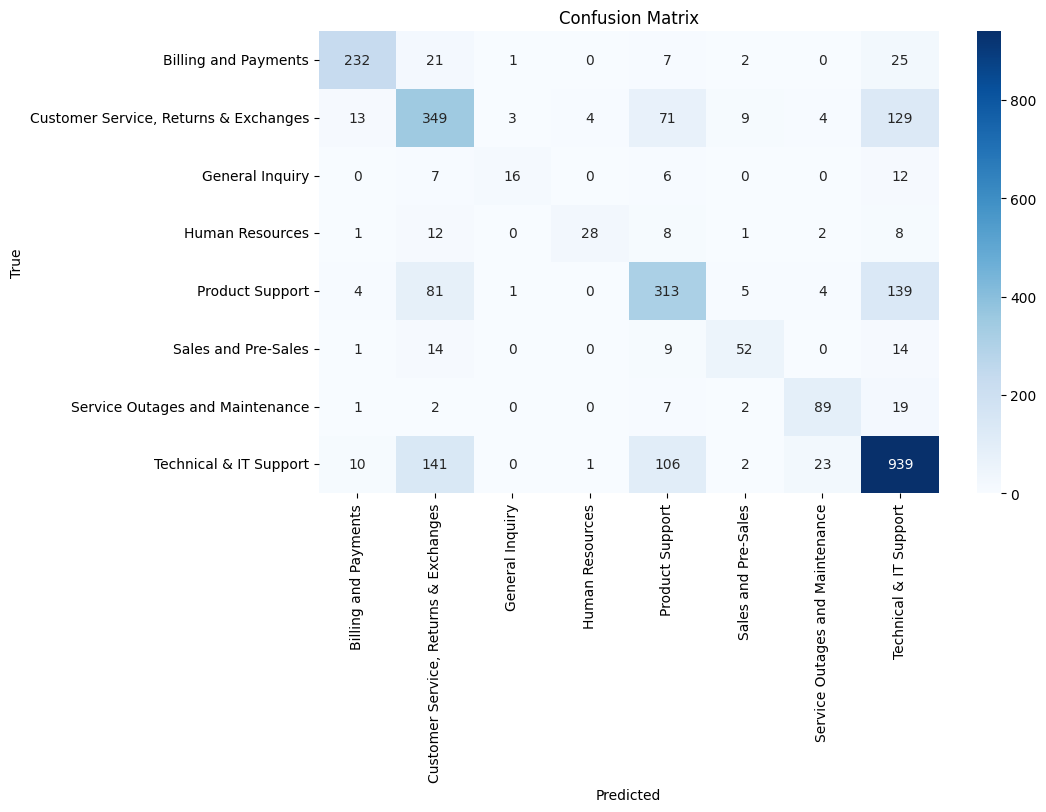

In [10]:
#confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues",
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [11]:
#save model and components
dump(clf, "../models/xgb.joblib", compress=3)

['../models/xgb.joblib']